<a href="https://colab.research.google.com/github/HerzelS/machine_learning/blob/main/fcc_bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

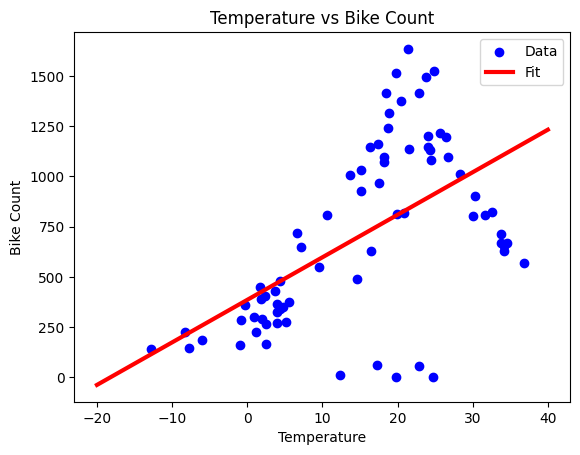

In [ ]:
plt.scatter(x_test_temp, y_test_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Temperature vs Bike Count")
plt.xlabel("Temperature")
plt.ylabel("Bike Count")
plt.show()

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

### Dataset:

Seoul Bike Sharing Demand [Dataset]. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.

In [33]:
dataset_cols = ['bike_count', 'hour', 'temp','humidity','wind','visibility','dew_pt_temp','radiation', 'rain', 'snow', 'functional']

In [34]:
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1').drop(['Date', 'Seasons', 'Holiday'], axis=1)
df.head()


,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [35]:
df.columns = dataset_cols
df['functional'] = (df['functional'] == "Yes").astype(int)
df = df[df['hour'] == 12]
df.drop(['hour'], axis=1)
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,12,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,12,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,12,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,12,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,12,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


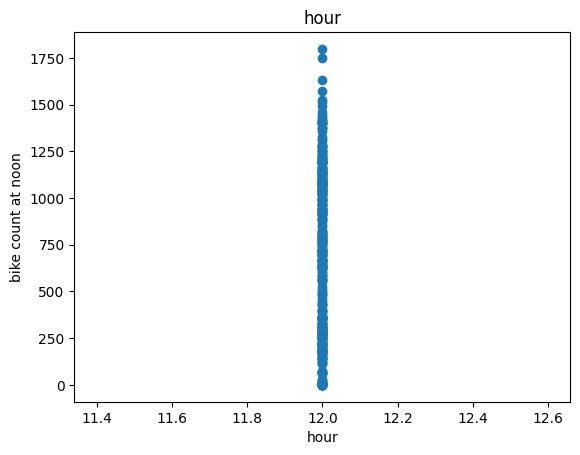

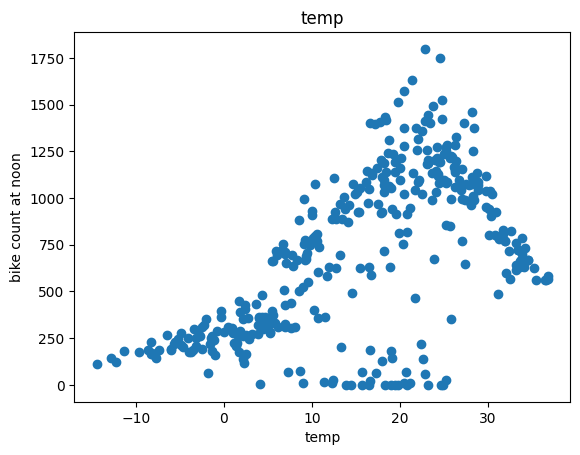

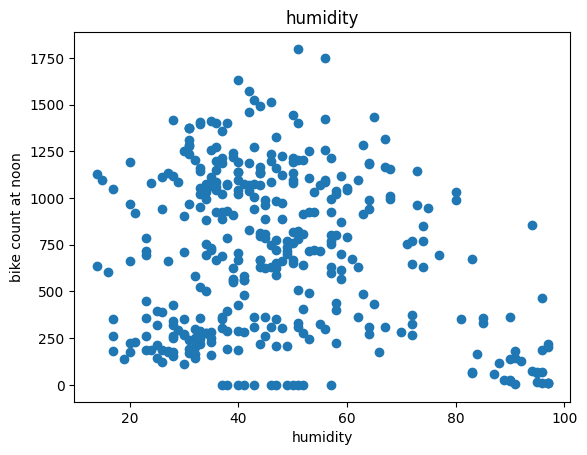

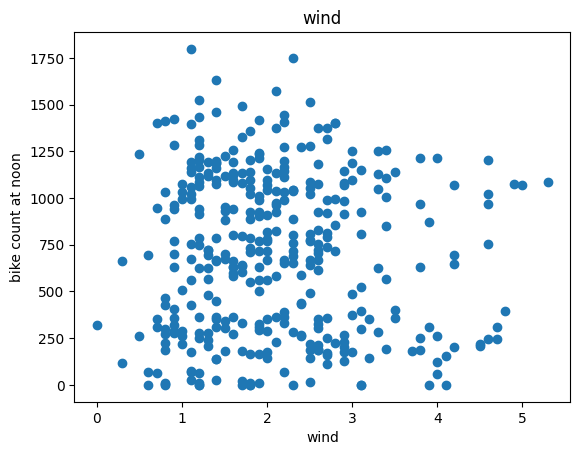

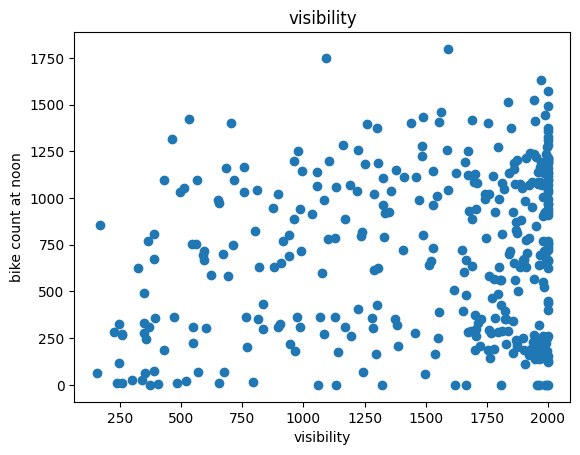

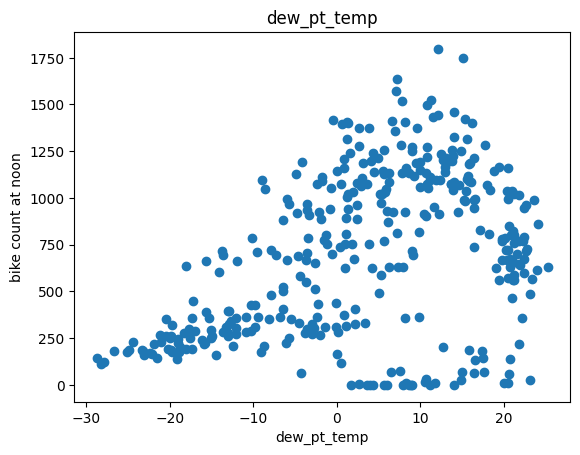

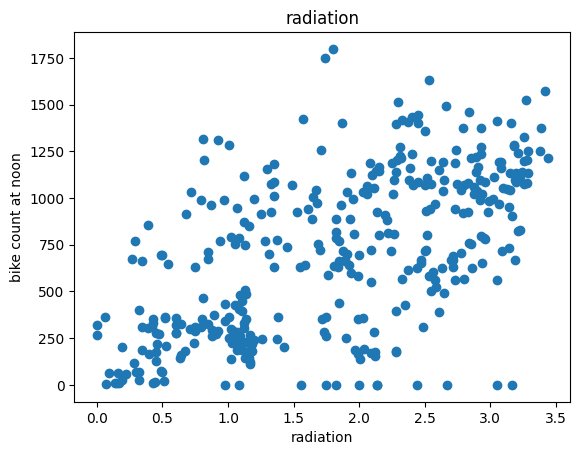

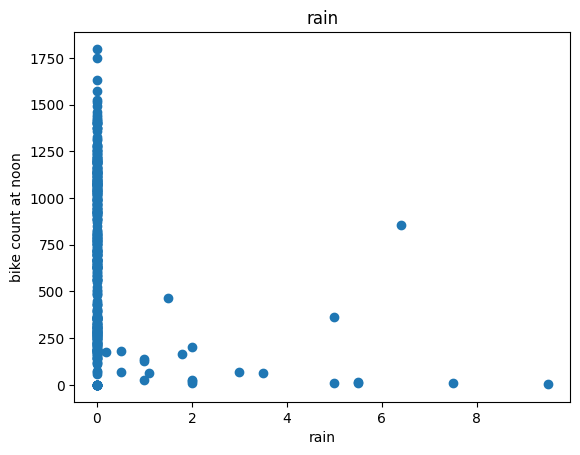

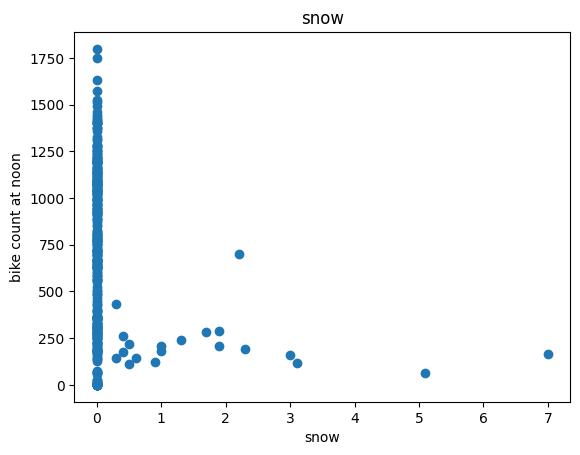

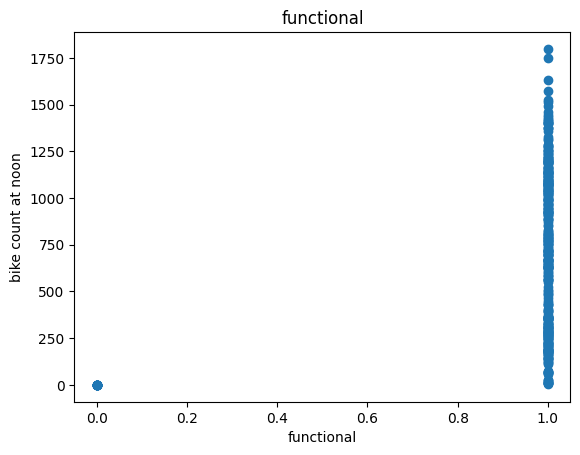

In [36]:
for label in df.columns[1:]:
  plt.scatter(df[label], df['bike_count'])
  plt.title(label)
  plt.ylabel('bike count at noon')
  plt.xlabel(label)
  plt.show()

In [37]:
df = df.drop(['wind', 'visibility', 'functional'], axis=1)

In [38]:
df.head()

,bike_count,hour,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,12,1.7,23,-17.2,1.11,0.0,0.0
36,479,12,4.3,41,-7.8,1.09,0.0,0.0
60,333,12,5.8,85,3.4,0.43,0.0,0.0
84,393,12,-0.3,38,-12.9,1.11,0.0,0.0
108,321,12,-2.3,25,-19.7,0.00,0.0,0.0


In [67]:
# Train, Validation, Test
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [68]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    x = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if len(x_labels) == 1:
      x = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      x = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack([x, y])

  return data, x, y

---
title: "Explanation of get_xy Function"
output: html_document
---

```python
import numpy as np
import copy

def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)  # Step 1: Make a deep copy of the DataFrame to avoid modifying the original

    # Step 2: Extract features (x)
    if not x_labels:
        # If no specific x_labels provided, use all columns except y_label
        x = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        if len(x_labels) == 1:
            # If only one feature is given, reshape to 2D
            x = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            # If multiple features are given
            x = dataframe[x_labels].values

    # Step 3: Extract target (y)
    y = dataframe[y_label].values.reshape(-1, 1)

    # Step 4: Combine features and target into one data array
    data = np.hstack([x, y])

    # Step 5: Return all arrays
    return data, x, y
```

### Function Parameters:

- `dataframe`: A pandas DataFrame containing your data.
- `y_label`: The column name of the target variable.
- `x_labels`: (Optional) A list of column names to use as features. If not provided, all columns except the target are used.

### Explanation:

1. **Copy the dataframe**
   - Prevents modification of the original data.

2. **Determine `x` (features)**
   - If `x_labels` is `None`, selects all columns except `y_label`.
   - If `x_labels` has one column, reshapes it to be 2D.
   - If multiple, selects the listed columns.

3. **Determine `y` (target)**
   - Extracts and reshapes the `y_label` column.

4. **Combine x and y into one array**
   - Uses `np.hstack()` to horizontally stack `x` and `y`.

5. **Return Values**
   - `data`: combined `x` and `y`
   - `x`: feature array
   - `y`: target array

### Example Usage:

```python
import pandas as pd

# Sample data
df = pd.DataFrame({
    'temp': [20, 25, 30],
    'humidity': [80, 70, 60],
    'bike_count': [100, 200, 300]
})

# Call the function
data, x, y = get_xy(df, 'bike_count', x_labels=['temp'])

# Output:
# x = [[20], [25], [30]]
# y = [[100], [200], [300]]
# data = [[20, 100], [25, 200], [30, 300]]


In [69]:
_, x_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels=['temp'])
_, x_val_temp, y_val_temp = get_xy(val, 'bike_count', x_labels=['temp'])
_, x_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])


In [70]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [71]:
print(temp_reg.coef_, temp_reg.intercept_)

[[21.15847882]] [385.87776419]


In [72]:
temp_reg.score(x_test_temp, y_test_temp)

0.3149735197489292

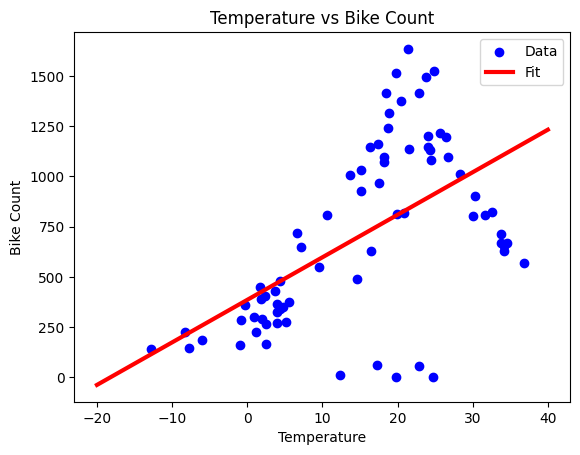

In [73]:
plt.scatter(x_test_temp, y_test_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Temperature vs Bike Count")
plt.xlabel("Temperature")
plt.ylabel("Bike Count")
plt.show()

# Multiple lenear regression

In [77]:
_, x_train_all, y_train_all = get_xy(train, 'bike_count', x_labels=df.columns[1:])
_, x_val_all, y_val_all = get_xy(val, 'bike_count', x_labels=df.columns[1:])
_, x_test_all, y_test_all = get_xy(test, 'bike_count', x_labels=df.columns[1:])

In [78]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [79]:
all_reg.score(x_test_all, y_test_all)

0.4323596400655505

# Regression with neural network

In [88]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [81]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))
#

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [82]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(units=1)
])

In [86]:
temp_nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error'
)

In [87]:
history = temp_nn_model.fit(
    x_train_temp, y_train_temp,
    epochs=1000,
    verbose=0,
    validation_data=(x_val_temp, y_val_temp)
)

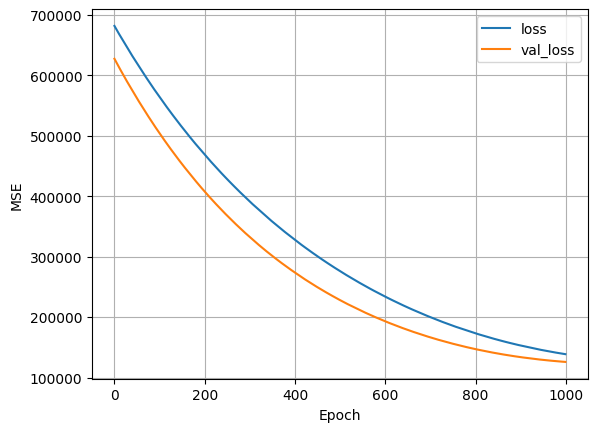

In [89]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


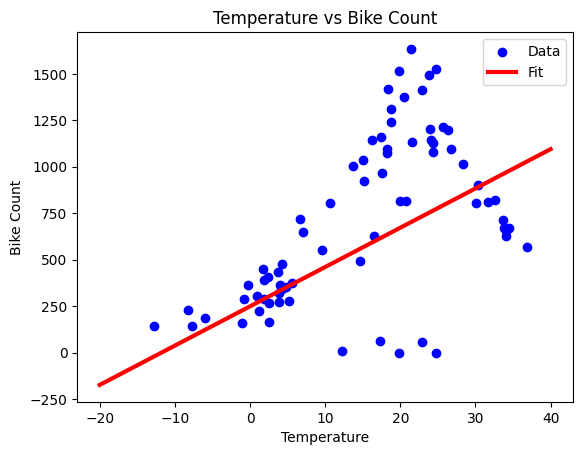

In [90]:
plt.scatter(x_test_temp, y_test_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Temperature vs Bike Count")
plt.xlabel("Temperature")
plt.ylabel("Bike Count")
plt.show()

# Neural Net